# Running ASFMAUS

In [1]:
using StochasticDiffEq
using DiffEqCallbacks
using DifferentialEquations
using Plots
using LinearAlgebra
using DelimitedFiles
using DataFrames
using LinearAlgebra
using SparseArrays
using Distributions

In [2]:
include("/home/callum/ASF/Modules/ASF_input.jl");
include("/home/callum/ASF/Modules/ASF_model.jl");
include("/home/callum/ASF/Modules/ASF_analysis.jl");

In [3]:
input_path = "/home/callum/ASF/Inputs/"

"/home/callum/ASF/Inputs/"

In [6]:
input_1 = ASF_Inputs.Model_Data(input_path); #creating parameters to run model

In [7]:
nt = input_1.Parameters.Populations.cum_sum[end] #total number of groups and farms
nc = 5 #number of classes
eqs = 11 #number of processes
n_ens = 100 #number of runs in ensemble

dc = sparse(zeros(nt*nc,nt*eqs))

#const _dc = zeros(nt*5,nt*10)

dc[0*nc*nt+1:nc*nt*eqs+nc:end] .= 1
dc[1*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[2*nc*nt+1:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+1:nc*nt*eqs+nc:end] .= 1

dc[2*nc*nt+2:nc*nt*eqs+nc:end] .= 1
dc[3*nc*nt+2:nc*nt*eqs+nc:end] .= -1
dc[4*nc*nt+2:nc*nt*eqs+nc:end] .= -1

dc[4*nc*nt+3:nc*nt*eqs+nc:end] .= 1
dc[5*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[6*nc*nt+3:nc*nt*eqs+nc:end] .= -1
dc[7*nc*nt+3:nc*nt*eqs+nc:end] .= -1

dc[7*nc*nt+4:nc*nt*eqs+nc:end] .= 1
dc[8*nc*nt+4:nc*nt*eqs+nc:end] .= -1
dc[10*nc*nt+4:nc*nt*eqs+nc:end] .= -1


dc[5*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[6*nc*nt+5:nc*nt*eqs+nc:end] .= 1
dc[9*nc*nt+5:nc*nt*eqs+nc:end] .= -1;

In [8]:
function regular_c(du,u,p,t,counts,mark)  
    mul!(du,dc,counts)
end

function prob_func(prob,i,repeat) #function to change parameters while keeping network the same
                ASF_Model.reparam!(input_1)
                remake(prob,p=input_1.Parameters)
end 

prob_func (generic function with 1 method)

## Running the Model

### Frequency run

In [136]:
u0 = [1.,0.]
function fun2(du,u,p,t)
   du[2] = -u[1]
   du[1] = u[2]
end
tspan = (0.0,10.0)
prob = ODEProblem(fun2,u0,tspan)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 0.0

In [147]:
sol = solve(prob,Tsit5(),callback=cb);

TypeError: TypeError: non-boolean (BitVector) used in boolean context

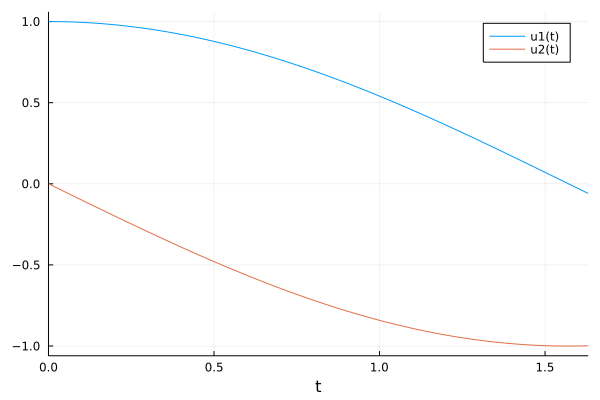

In [145]:
plot(sol)

In [58]:
input_1 = ASF_Inputs.Model_Data(directory_path); #creating parameters to run model

In [100]:
a= [ 1,2,3,3]

4-element Vector{Int64}:
 1
 2
 3
 3

In [103]:
a .< 0

4-element BitVector:
 0
 0
 0
 0

In [146]:


#sum(u[2:5:end]+u[3:5:end]+u[5:5:end])<1

function condition(u,t,integrator) 
    u .< -1 
end
#function condition(u,t,integrator)
#    sum(u[2:5:end]+u[3:5:end]+u[5:5:end])=0
#end 
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition,affect!)


DiscreteCallback{typeof(condition), typeof(affect!), typeof(DiffEqBase.INITIALIZE_DEFAULT), typeof(DiffEqBase.FINALIZE_DEFAULT)}(condition, affect!, DiffEqBase.INITIALIZE_DEFAULT, DiffEqBase.FINALIZE_DEFAULT, Bool[1, 1])

In [ ]:
cb = PresetTimeCallback(Times,affect!)


In [1]:
rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)

jumps = JumpSet(rj)

prob = DiscreteProblem(input_1.U0,input_1.Time,input_1.Parameters)

jump_prob = JumpProblem(prob,Direct(),rj) #rng=rng)

sol = solve(jump_prob, SimpleTauLeaping(),dt=1, DiscreteCallback= cb)

#ensemble_prob_m = EnsembleProblem(jump_prob)#,prob_func=prob_func)
#output = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= 10,dt=1);

UndefVarError: UndefVarError: ASF_Model not defined

In [153]:
sol

retcode: Default
Interpolation: Piecewise constant interpolation
t: 0.0:1.0:3650.0
u: 3651-element Vector{Vector{Int64}}:
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 [6, 0, 0, 0, 0, 8, 0, 0, 0, 0  …  8, 0, 0, 0, 0, 6, 0, 0, 0, 0]
 ⋮
 [5, 0, 0, 0, 0, 36, 0, 0, 0, 0  …  5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 36, 0, 0, 0, 0  …  5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 36, 0, 0, 0, 0  …  5, 0, 0, 0, 0, 1, 0, 0, 0, 0]
 [5, 0, 0, 0, 0, 36, 0, 0, 

In [116]:
data = reduce(vcat,transpose.(sol.u))


3651×500 Matrix{Int64}:
 6  0  0  0  0  8  0  0  0  0   5  0  …  0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0  …  0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 6  0  0  0  0  8  0  0  0  0   5  0     0  0  8  0  0  0  0  6  0  0  0  0
 ⋮              ⋮               ⋮     ⋱        ⋮              ⋮           
 3  0  0  0  0  5  0  0  0  0  14  0     0  0  3  0  0  0  0  1  0  0  0  0
 3  0  0  0  0  5  0  0  0  0  14  0     0  0  3  0  0  0  0  1  

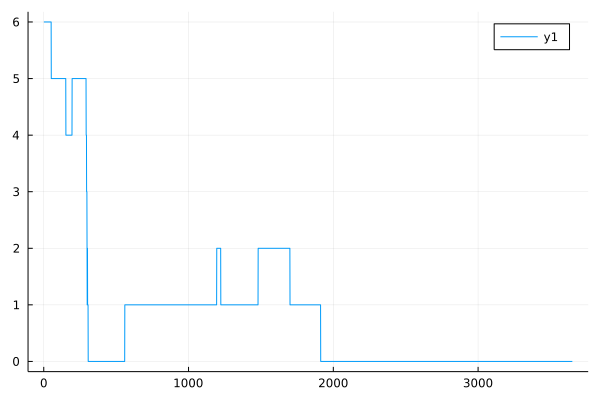

In [125]:
plot(sol[1,:])

In [77]:

sol.t

0.0:1.0:3650.0

In [72]:
sol = output[1]

data = reduce(vcat,transpose.(sol.u))

        

s_d = data[:,1:5:end]
e_d = data[:,2:5:end]
i_d = data[:,3:5:end]
r_d = data[:,4:5:end]
c_d = data[:,5:5:end]

sol.t

0.0:1.0:3650.0

In [18]:
Summary = ASF_Analysis.quick_analysis(output)

100×3 Matrix{Int64}:
 67  75  596
 66  79  370
 59  76  533
 63  81  391
 64  79  635
 57  80  529
 57  78  721
 51  78  607
 50  86  401
 48  84  400
  ⋮      
 63  75  529
 57  79  443
 71  77  668
 75  57  484
 60  82  450
 56  77  451
 57  79  469
 61  81  620
 50  81  497

## Running Multiple Networks

In [13]:
function sensitivity(n_networks, n_dist, n_runs, path, name)
    
    input_folder = splitpath(path)[end]
    base_path = rsplit(path, input_folder)[1]

    #making save directory
    dir = "$(base_path)Results/$(name)"

    isdir(dir) || mkdir(dir)
    cd(dir)

    #copying inputs
    cp("$(path)", "Inputs",force = true)
    
    for i = 1:n_networks
        inputs = ASF_Inputs.Model_Data(path); #creating parameters to run model
        for j = 1:n_dist

            rj = RegularJump(ASF_Model.density_rate,regular_c,eqs*nt)
            jumps = JumpSet(rj)
            prob = DiscreteProblem(inputs.U0,inputs.Time,inputs.Parameters)
            jump_prob = JumpProblem(prob,Direct(),rj) 
            ensemble_prob_m = EnsembleProblem(jump_prob)
            outputs = solve(ensemble_prob_m, SimpleTauLeaping(), trajectories= n_runs,EnsembleThreads(),dt=1);

            summary = ASF_Analysis.quick_analysis(outputs) #update to new function from module (ASF_Model.quick_analysis(outputs))

            writedlm( "Results_$(i)_$(j).csv",  summary, ',')
            ASF_Model.reparam!(inputs) #re-doing params with
        end
        println("$(100*i/n_networks) %")

    end
    
end

sensitivity (generic function with 1 method)

In [14]:
sensitivity(20,20,100,input_path, "Dataout") # running 

TaskFailedException: TaskFailedException

    nested task error: InterruptException:
    Stacktrace:
      [1] Array
        @ ./boot.jl:448 [inlined]
      [2] Array
        @ ./boot.jl:457 [inlined]
      [3] Array
        @ ./boot.jl:465 [inlined]
      [4] similar
        @ ./abstractarray.jl:785 [inlined]
      [5] similar
        @ ./abstractarray.jl:784 [inlined]
      [6] similar
        @ ./broadcast.jl:197 [inlined]
      [7] similar
        @ ./broadcast.jl:196 [inlined]
      [8] copy
        @ ./broadcast.jl:908 [inlined]
      [9] materialize
        @ ./broadcast.jl:883 [inlined]
     [10] density_rate(out::Vector{Float64}, u::Vector{Int64}, p::Main.ASF_Inputs.Model_Parameters, t::Float64)
        @ Main.ASF_Model ~/ASF/Modules/ASF_model.jl:50
     [11] solve(jump_prob::JumpProblem{true, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Main.ASF_Inputs.Model_Parameters, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, Direct, CallbackSet{Tuple{}, Tuple{}}, Nothing, Tuple{}, RegularJump{true, typeof(Main.ASF_Model.density_rate), typeof(regular_c), Nothing}, Nothing}, alg::SimpleTauLeaping; seed::Nothing, dt::Int64)
        @ DiffEqJump ~/.julia/packages/DiffEqJump/x05Qi/src/simple_regular_solve.jl:40
     [12] #batch_func#460
        @ ~/.julia/packages/SciMLBase/h4Gxc/src/ensemble/basic_ensemble_solve.jl:143 [inlined]
     [13] #469
        @ ~/.julia/packages/SciMLBase/h4Gxc/src/ensemble/basic_ensemble_solve.jl:213 [inlined]
     [14] macro expansion
        @ ~/.julia/packages/SciMLBase/h4Gxc/src/ensemble/basic_ensemble_solve.jl:221 [inlined]
     [15] (::SciMLBase.var"#446#threadsfor_fun#472"{SciMLBase.var"#469#471"{Base.Iterators.Pairs{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:dt,), Tuple{Int64}}}, EnsembleProblem{JumpProblem{true, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Main.ASF_Inputs.Model_Parameters, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, Direct, CallbackSet{Tuple{}, Tuple{}}, Nothing, Tuple{}, RegularJump{true, typeof(Main.ASF_Model.density_rate), typeof(regular_c), Nothing}, Nothing}, typeof(SciMLBase.DEFAULT_PROB_FUNC), typeof(SciMLBase.DEFAULT_OUTPUT_FUNC), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, SimpleTauLeaping}, Tuple{UnitRange{Int64}}, Vector{ODESolution{Int64, 2, Vector{Vector{Int64}}, Nothing, Nothing, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Nothing, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Main.ASF_Inputs.Model_Parameters, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, SimpleTauLeaping, SciMLBase.ConstantInterpolation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Vector{Vector{Int64}}}, Nothing}}, UnitRange{Int64}})(onethread::Bool)
        @ SciMLBase ./threadingconstructs.jl:81
     [16] (::SciMLBase.var"#446#threadsfor_fun#472"{SciMLBase.var"#469#471"{Base.Iterators.Pairs{Symbol, Int64, Tuple{Symbol}, NamedTuple{(:dt,), Tuple{Int64}}}, EnsembleProblem{JumpProblem{true, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Main.ASF_Inputs.Model_Parameters, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, Direct, CallbackSet{Tuple{}, Tuple{}}, Nothing, Tuple{}, RegularJump{true, typeof(Main.ASF_Model.density_rate), typeof(regular_c), Nothing}, Nothing}, typeof(SciMLBase.DEFAULT_PROB_FUNC), typeof(SciMLBase.DEFAULT_OUTPUT_FUNC), typeof(SciMLBase.DEFAULT_REDUCTION), Nothing}, SimpleTauLeaping}, Tuple{UnitRange{Int64}}, Vector{ODESolution{Int64, 2, Vector{Vector{Int64}}, Nothing, Nothing, StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Nothing, DiscreteProblem{Vector{Int64}, Tuple{Float64, Float64}, true, Main.ASF_Inputs.Model_Parameters, DiscreteFunction{true, SciMLBase.var"#158#159", Nothing, Nothing}, Base.Iterators.Pairs{Union{}, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}}, SimpleTauLeaping, SciMLBase.ConstantInterpolation{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}}, Vector{Vector{Int64}}}, Nothing}}, UnitRange{Int64}})()
        @ SciMLBase ./threadingconstructs.jl:48

## Analysing Output

In [ ]:
density = ASF_Analysis.read_outputs("/home/callum/ASF/Results/Baseline//");
connect_5 = ASF_Analysis.read_outputs("/home/callum/ASF/Results/Connect_5//");


In [ ]:
density_r = ASF_Analysis.three_statistics(density,20, p_out = true);

In [ ]:
connect_5_r = ASF_Analysis.three_statistics(connect_5,20, p_out = true);